Load dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance
import datetime
import pytz


In [5]:
import pandas as pd
from google.oauth2 import service_account
import pandas as pd
import pandas_gbq as gbq 
import json
from pandas_gbq import to_gbq, read_gbq
import matplotlib.pyplot as plt
import seaborn as sns

credentials_path = '../token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [6]:
data = read_gbq(f"""

SELECT *
FROM capstone-402105.capstone.cri_compustat_yfinance_data

""",project_id='capstone-402105', dialect='standard')

Downloading:   6%|▌         |

KeyboardInterrupt: 

Downloading:   6%|▌         |

In [45]:
data = pd.read_pickle('cri_compustat_yfinance.pkl')

In [8]:
data.shape

(579815, 61)

In [9]:
data.isna().sum().sort_values(ascending=False)

CompNo                 0
tic                    0
quick_ratio            0
cash_ratio             0
net_working_capital    0
                      ..
Default_12             0
Default_24             0
Default_36             0
Default_60             0
rsi                    0
Length: 61, dtype: int64

In [27]:
data.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'StartDate',
       'EventDate', 'Default_1', 'Default_3', 'Default_6', 'Default_12',
       'Default_24', 'Default_36', 'Default_60', 'Duration', 'gvkey', 'tic',
       'current_ratio', 'quick_ratio', 'cash_ratio', 'net_working_capital',
       'debt_ratio', 'debt_to_equity_ratio', 'equity_ratio',
       'cashflow_to_debt_ratio', 'net_profit_margin', 'return_on_assets',
       'asset_turnover', 'inventory_turnover', 'days_in_inventory',
       'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 

top features

In [13]:
#load compna to get sic
compna = read_gbq(f"""

SELECT *
FROM capstone-402105.raw_data.sic_map

""",project_id='capstone-402105', dialect='standard')

Downloading: 100%|██████████|


In [14]:
data.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'StartDate',
       'EventDate', 'Default_1', 'Default_3', 'Default_6', 'Default_12',
       'Default_24', 'Default_36', 'Default_60', 'Duration', 'gvkey', 'tic',
       'current_ratio', 'quick_ratio', 'cash_ratio', 'net_working_capital',
       'debt_ratio', 'debt_to_equity_ratio', 'equity_ratio',
       'cashflow_to_debt_ratio', 'net_profit_margin', 'return_on_assets',
       'asset_turnover', 'inventory_turnover', 'days_in_inventory',
       'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 

In [15]:
#create tic sic mapping
sic_map = compna[['tic', 'sic']]
sic_map= sic_map.drop_duplicates(subset=['tic'])

In [16]:
sic_map

,tic,sic
0,TT.2,3585
1,CUO,3585
2,DOV,3585
3,EASI.1,3585
4,FJCC,3585
...,...,...
30207,CNSF.1,6399
30208,TRUP,6399
30209,BNRE,6399
30210,PTHLF,6399


In [46]:
#map sic to data
data['sic'] = data['tic'].map(sic_map.set_index('tic')['sic'])
data

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio,Rolling_Sortino,macd,macd_h,macd_s,rsi,sic
0,27063,2001.0,1,-0.020346,0.008312,1.734115,0.532625,0.000000,0.000000e+00,0.001818,...,-7.200393e+01,-6.773084e+01,-0.532897,7.307692,0.157160,1.121476,0.283435,0.838041,55.917874,6411
1,27171,2001.0,1,-0.020346,0.008312,15.692515,0.667361,0.000000,0.000000e+00,0.007375,...,4.254764e+01,1.285674e+00,-0.012316,2.129575,0.005584,-0.002415,-0.007975,0.005560,50.000000,6798
2,27688,2001.0,1,-0.020346,0.008312,4.759151,-0.100420,0.000000,0.000000e+00,0.005402,...,2.066238e+01,1.285674e+00,0.020848,2.129575,0.613843,0.620971,0.168450,0.452520,84.971098,6798
3,28070,2001.0,1,-0.020346,0.008312,1.857240,-0.127810,0.000000,0.000000e+00,0.001803,...,-4.970760e+01,-4.110276e+01,-0.445693,12.541667,0.129854,1.460809,-0.254475,1.715283,54.195423,6282
4,28137,2001.0,1,-0.020346,0.008312,7.015515,-2.572958,0.000000,0.000000e+00,0.003375,...,-5.742397e+01,-5.397864e+01,-0.204853,5.072468,0.721199,-0.334895,-0.777326,0.442431,88.120104,7011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579810,92273,2022.0,12,-0.144284,-0.010290,3.465149,0.573771,-0.676380,2.475355e-01,0.027357,...,3.231629e+01,4.879485e+01,0.627414,59.337325,0.522190,2.796406,0.574293,2.222113,71.065639,1311
579811,92290,2022.0,12,-0.144284,-0.010290,4.824300,-0.734144,0.253173,5.551115e-17,0.003601,...,-8.232769e+01,-7.986772e+01,-1.017642,5.062500,-0.210745,-1.912836,-0.864331,-1.048505,37.357371,5172
579812,92302,2022.0,12,-0.144284,-0.010290,2.714453,0.147446,-0.521602,3.094185e-01,0.014826,...,1.248066e+02,1.559232e+02,0.702222,27.139548,0.380031,0.876390,0.048411,0.827979,57.969729,1311
579813,92310,2022.0,12,-0.144284,-0.010290,1.784645,0.335266,-1.340583,6.242927e-01,0.012767,...,3.940032e+02,4.206915e+02,3.153048,59.842105,0.329632,1.467115,0.037905,1.429211,53.769936,1311


In [47]:
top_features = ['net_working_capital', 'DTDmedianNonFin', 'debt_ratio', 'm2b', 'working_capital_turnover']


In [48]:
for col in top_features:
    new_col_name = col + '_industry_avg'
    data[new_col_name] = data.groupby('sic')[col].transform('mean')

In [49]:
data

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,macd,macd_h,macd_s,rsi,sic,net_working_capital_industry_avg,DTDmedianNonFin_industry_avg,debt_ratio_industry_avg,m2b_industry_avg,working_capital_turnover_industry_avg
0,27063,2001.0,1,-0.020346,0.008312,1.734115,0.532625,0.000000,0.000000e+00,0.001818,...,1.121476,0.283435,0.838041,55.917874,6411,372.760844,0.787496,0.150497,1.828232,1.781622
1,27171,2001.0,1,-0.020346,0.008312,15.692515,0.667361,0.000000,0.000000e+00,0.007375,...,-0.002415,-0.007975,0.005560,50.000000,6798,-32.488959,0.017193,0.561950,0.996649,-0.108899
2,27688,2001.0,1,-0.020346,0.008312,4.759151,-0.100420,0.000000,0.000000e+00,0.005402,...,0.620971,0.168450,0.452520,84.971098,6798,-32.488959,0.017193,0.561950,0.996649,-0.108899
3,28070,2001.0,1,-0.020346,0.008312,1.857240,-0.127810,0.000000,0.000000e+00,0.001803,...,1.460809,-0.254475,1.715283,54.195423,6282,150.640625,0.220974,0.149348,2.096581,0.465850
4,28137,2001.0,1,-0.020346,0.008312,7.015515,-2.572958,0.000000,0.000000e+00,0.003375,...,-0.334895,-0.777326,0.442431,88.120104,7011,-162.780212,2.033281,0.490760,1.550594,0.237650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579810,92273,2022.0,12,-0.144284,-0.010290,3.465149,0.573771,-0.676380,2.475355e-01,0.027357,...,2.796406,0.574293,2.222113,71.065639,1311,129.594576,3.529658,0.262425,1.226824,0.657219
579811,92290,2022.0,12,-0.144284,-0.010290,4.824300,-0.734144,0.253173,5.551115e-17,0.003601,...,-1.912836,-0.864331,-1.048505,37.357371,5172,225.459711,3.792370,0.293822,0.962225,3.066412
579812,92302,2022.0,12,-0.144284,-0.010290,2.714453,0.147446,-0.521602,3.094185e-01,0.014826,...,0.876390,0.048411,0.827979,57.969729,1311,129.594576,3.529658,0.262425,1.226824,0.657219
579813,92310,2022.0,12,-0.144284,-0.010290,1.784645,0.335266,-1.340583,6.242927e-01,0.012767,...,1.467115,0.037905,1.429211,53.769936,1311,129.594576,3.529658,0.262425,1.226824,0.657219


In [50]:
#compute relative ratio
data['relative_net_working_capital'] = ((data['net_working_capital'] - data['net_working_capital_industry_avg']) / data['net_working_capital_industry_avg']) * 100
data['relative_debt_ratio'] = ((data['debt_ratio'] - data['debt_ratio_industry_avg']) / data['debt_ratio_industry_avg']) * 100
data['relative_DTDmedianNonFin'] = ((data['DTDmedianNonFin'] - data['DTDmedianNonFin_industry_avg']) / data['DTDmedianNonFin_industry_avg']) * 100
data['relative_m2b'] = ((data['m2b'] - data['m2b_industry_avg']) / data['m2b_industry_avg']) * 100
data['relative_working_capital_turnover'] = ((data['working_capital_turnover'] - data['working_capital_turnover_industry_avg']) / data['working_capital_turnover_industry_avg']) * 100

In [51]:
data['net_working_capital_industry_avg']

0         372.760844
1         -32.488959
2         -32.488959
3         150.640625
4        -162.780212
             ...    
579810    129.594576
579811    225.459711
579812    129.594576
579813    129.594576
579814    346.475945
Name: net_working_capital_industry_avg, Length: 579815, dtype: float64

In [52]:
data.isna().sum().sort_values(ascending= False)

relative_DTDmedianNonFin             33400
relative_debt_ratio                    109
CompNo                                   0
receivables_turnover                     0
gross_margin_ratio                       0
                                     ...  
Default_3                                0
Default_1                                0
EventDate                                0
StartDate                                0
relative_working_capital_turnover        0
Length: 72, dtype: int64

In [53]:
data[data.isna().any(axis=1)]

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,net_working_capital_industry_avg,DTDmedianNonFin_industry_avg,debt_ratio_industry_avg,m2b_industry_avg,working_capital_turnover_industry_avg,relative_net_working_capital,relative_debt_ratio,relative_DTDmedianNonFin,relative_m2b,relative_working_capital_turnover
8,30614,2001.0,1,-0.020346,0.008312,1.920973,-0.230412,0.0,0.0,0.002342,...,17.967811,0.0,0.055538,0.800862,2.632996,-92.186027,-33.635110,NaN,8.947539,-57.356083
9,30618,2001.0,1,-0.020346,0.008312,2.305002,0.560577,0.0,0.0,-0.000350,...,17.967811,0.0,0.055538,0.800862,2.632996,-92.186027,48.453431,NaN,11.669918,-57.356083
15,34049,2001.0,1,-0.020346,0.008312,2.040706,0.429608,0.0,0.0,0.001754,...,17.967811,0.0,0.055538,0.800862,2.632996,-92.186027,-32.034739,NaN,16.685814,-57.356083
19,38553,2001.0,1,-0.020346,0.008312,1.046221,0.261284,0.0,0.0,0.000858,...,21.464229,0.0,0.188420,0.805169,-0.072941,1.443195,38.058846,NaN,2.034739,-355.771025
22,44294,2001.0,1,-0.020346,0.008312,0.589140,-0.558245,0.0,0.0,0.003042,...,17.967811,0.0,0.055538,0.800862,2.632996,-92.186027,226.623469,NaN,-8.241541,-57.356083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579547,29657,2022.0,12,-0.196544,0.005723,1.327867,-1.343301,0.0,0.0,-0.006124,...,17.967811,0.0,0.055538,0.800862,2.632996,1399.503713,17.468850,NaN,-10.761473,-75.161145
579549,30618,2022.0,12,-0.196544,0.005723,5.601484,-0.180878,0.0,0.0,-0.000524,...,17.967811,0.0,0.055538,0.800862,2.632996,1399.503713,68.444214,NaN,6.416466,-75.161145
579554,34049,2022.0,12,-0.196544,0.005723,4.185621,-0.894950,0.0,0.0,0.000102,...,17.967811,0.0,0.055538,0.800862,2.632996,1399.503713,52.692009,NaN,14.952917,-75.161145
579555,34425,2022.0,12,-0.196544,0.005723,-0.457320,-0.555553,0.0,0.0,-0.004974,...,17.967811,0.0,0.055538,0.800862,2.632996,1399.503713,-2.173777,NaN,-4.405302,-75.161145


In [54]:
data.dropna(inplace=True)
df = data

In [55]:
for col in top_features:
    new_col_name = col + '_industry_avg'
    df.drop(columns = [new_col_name], inplace=True)

In [56]:
cols = list(df.columns)

df.sort_values(by='EventDate', inplace=True)
date2022 = datetime.datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
date2020 = datetime.datetime(2020,1,1).replace(tzinfo=pytz.UTC)
train_df = df[df["EventDate"] < date2020]
validation_df = df[(df["EventDate"] >= date2020) & (df["EventDate"] < date2022)]
test_df = df[df["EventDate"] >= date2022]

In [57]:
train_df = train_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])
validation_df = validation_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])
test_df = test_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])

In [58]:
x_train = train_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_train = train_df['Default_12']
x_validation = validation_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_validation = validation_df['Default_12']
x_test = test_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_test = test_df["Default_12"]

In [99]:
x_train.columns

Index(['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'DTDmedianNonFin', 'dummy297fin', 'current_ratio', 'quick_ratio',
       'cash_ratio', 'net_working_capital', 'debt_ratio',
       'debt_to_equity_ratio', 'equity_ratio', 'cashflow_to_debt_ratio',
       'net_profit_margin', 'return_on_assets', 'asset_turnover',
       'inventory_turnover', 'days_in_inventory', 'receivables_turnover',
       'day_sales_outstanding', 'working_capital_turnover',
       'price_to_earnings', 'dividend_payout_ratio', 'retention_ratio',
       'gross_margin_ratio', 'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio',
       'Rolling_Sortino', 'macd', 'macd_h', 'macd_s', 'rsi',
       'relative_net_working_capital', 'relative_debt_ratio',
       'relative_debt_to_equity_ratio', 'relati

In [59]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'auc', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    if optimisation_metric == 'recall': 
        return recall
    elif optimisation_metric == 'precision': 
        return precision
    elif optimisation_metric == 'f1':
        return f1
    elif optimisation_metric == 'auc':
        return auc
    elif optimisation_metric == 'accuracy': 
        return accuracy
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-09 00:14:18,013] A new study created in memory with name: no-name-9fa82c3f-6dfc-4fdc-bc66-d5aa31493ca7
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:14:37,796] Trial 0 finished with value: 0.7992064493515597 and parameters: {'num_leaves': 244, 'lambda_l1': 2.076861724543498e-08, 'lambda_l2': 0.0015942574033470365, 'feature_fraction': 0.9392485431272714, 'min_child_samples': 55, 'learning_rate': 2.7679884131164334e-06, 'max_depth': 144, 'num_boost_round': 264}. Best is trial 0 with value: 0.7992064493515597.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2023-11-09 00:14:43,602] Trial 1 finished with value: 0.5281103782302521 and parameters: {'num_leaves': 194, 'lambda_l1': 5.396759356055077e-05, 'lambda_l2': 1.1698437035619147e-05, 'feature_fraction': 0.7800614418576766, 'min_child_samples': 10, 'learning_rate': 0.12183433362408753, 'max_depth': 239, 'num_boost_round': 164}. Best is trial 0 with value: 0.7992064493515597.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:14:59,788] Trial 2 finished with value: 0.9326829175031067 and parameters: {'num_leaves': 95, 'lambda_l1': 1.9783939744183232e-06, 'lambda_l2': 0.3182462935680072, 'feature_fraction': 0.5491256480730445, 'min_child_samples': 11, 'learning_rate': 9.552415773266495e-07, 'max_depth': 37, 'num_boost_round': 410}. Best is trial 2 with value: 0.9326829175031067.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No f

[I 2023-11-09 00:15:09,493] Trial 3 finished with value: 0.6932568588089093 and parameters: {'num_leaves': 173, 'lambda_l1': 0.00034425813842414726, 'lambda_l2': 4.619446929544602e-06, 'feature_fraction': 0.7802832921011165, 'min_child_samples': 48, 'learning_rate': 0.44761268605818466, 'max_depth': 25, 'num_boost_round': 333}. Best is trial 2 with value: 0.9326829175031067.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[I 2023-11-09 00:15:20,764] Trial 4 finished with value: 0.6435969792562851 and parameters: {'num_leaves': 23, 'lambda_l1': 1.3267809682396476, 'lambda_l2': 1.7188973435599524e-07, 'feature_fraction': 0.6789033939008995, 'min_child_samples': 64, 'learning_rate': 2.511597937327175, 'max_depth': 34, 'num_boost_round': 465}. Best is trial 2 with value: 0.9326829175031067.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[I 2023-11-09 00:15:31,831] Trial 5 finished with value: 0.5834145875155339 and parameters: {'num_leaves': 37, 'lambda_l1': 5.797855951229485e-07, 'lambda_l2': 6.223372610494497e-07, 'feature_fraction': 0.5774733863736637, 'min_child_samples': 27, 'learning_rate': 0.2685303930306795, 'max_depth': 52, 'num_boost_round': 436}. Best is trial 2 with value: 0.9326829175031067.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:15:44,950] Trial 6 finished with value: 0.9251918554631489 and parameters: {'num_leaves': 35, 'lambda_l1': 2.2192463319128015e-05, 'lambda_l2': 9.927880247972308e-07, 'feature_fraction': 0.6567734973995236, 'min_child_samples': 69, 'learning_rate': 3.66007162436632e-07, 'max_depth': 120, 'num_boost_round': 437}. Best is trial 2 with value: 0.9326829175031067.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No f

[I 2023-11-09 00:15:54,505] Trial 7 finished with value: 0.5042166140904312 and parameters: {'num_leaves': 213, 'lambda_l1': 5.761501656120041, 'lambda_l2': 2.06420103323593e-08, 'feature_fraction': 0.6723426602513161, 'min_child_samples': 45, 'learning_rate': 5.412863726801471, 'max_depth': 95, 'num_boost_round': 461}. Best is trial 2 with value: 0.9326829175031067.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:16:02,784] Trial 8 finished with value: 0.9324661122263647 and parameters: {'num_leaves': 174, 'lambda_l1': 9.763416916881361e-07, 'lambda_l2': 6.565853216613783e-05, 'feature_fraction': 0.6244360670225576, 'min_child_samples': 61, 'learning_rate': 1.1053903391353134e-05, 'max_depth': 232, 'num_boost_round': 156}. Best is trial 2 with value: 0.9326829175031067.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:16:07,915] Trial 9 finished with value: 0.9340255552369117 and parameters: {'num_leaves': 57, 'lambda_l1': 1.868492391926402e-08, 'lambda_l2': 1.631951334171245e-05, 'feature_fraction': 0.593764494165674, 'min_child_samples': 13, 'learning_rate': 9.779234732361773e-06, 'max_depth': 151, 'num_boost_round': 123}. Best is trial 9 with value: 0.9340255552369117.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:16:13,518] Trial 10 finished with value: 0.9196745371698052 and parameters: {'num_leaves': 99, 'lambda_l1': 3.147772414761835e-08, 'lambda_l2': 0.0011376759306648621, 'feature_fraction': 0.40186913240778144, 'min_child_samples': 81, 'learning_rate': 0.0005092694946126494, 'max_depth': 183, 'num_boost_round': 111}. Best is trial 9 with value: 0.9340255552369117.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:16:25,623] Trial 11 finished with value: 0.9310180671063952 and parameters: {'num_leaves': 100, 'lambda_l1': 1.7129448715013606e-08, 'lambda_l2': 0.819750694456882, 'feature_fraction': 0.5098445102183409, 'min_child_samples': 5, 'learning_rate': 1.0403700077844519e-08, 'max_depth': 171, 'num_boost_round': 322}. Best is trial 9 with value: 0.9340255552369117.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:16:33,928] Trial 12 finished with value: 0.9143602587388077 and parameters: {'num_leaves': 79, 'lambda_l1': 1.3787472808123914e-06, 'lambda_l2': 1.1820804254787294, 'feature_fraction': 0.5128150332930513, 'min_child_samples': 25, 'learning_rate': 0.00011768457153880982, 'max_depth': 78, 'num_boost_round': 239}. Best is trial 9 with value: 0.9340255552369117.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:16:41,688] Trial 13 finished with value: 0.9339582576554186 and parameters: {'num_leaves': 137, 'lambda_l1': 1.7937307482742213e-07, 'lambda_l2': 0.028578870677428352, 'feature_fraction': 0.5262519398754351, 'min_child_samples': 25, 'learning_rate': 1.1807826909539982e-07, 'max_depth': 5, 'num_boost_round': 360}. Best is trial 9 with value: 0.9340255552369117.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:16:53,648] Trial 14 finished with value: 0.9397356530605743 and parameters: {'num_leaves': 132, 'lambda_l1': 1.2102926827007317e-08, 'lambda_l2': 0.017435080827982223, 'feature_fraction': 0.43594208272307594, 'min_child_samples': 31, 'learning_rate': 1.3290917262457433e-08, 'max_depth': 192, 'num_boost_round': 345}. Best is trial 14 with value: 0.9397356530605743.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:17:01,664] Trial 15 finished with value: 0.9397522225408661 and parameters: {'num_leaves': 144, 'lambda_l1': 1.1192256861691689e-08, 'lambda_l2': 0.01054739733513341, 'feature_fraction': 0.4014176210786116, 'min_child_samples': 36, 'learning_rate': 1.7589770752123455e-08, 'max_depth': 199, 'num_boost_round': 239}. Best is trial 15 with value: 0.9397522225408661.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:17:09,928] Trial 16 finished with value: 0.9448737214415448 and parameters: {'num_leaves': 141, 'lambda_l1': 1.2211434128156428e-07, 'lambda_l2': 0.012104700324233775, 'feature_fraction': 0.4056729630452268, 'min_child_samples': 99, 'learning_rate': 1.2617893550695772e-08, 'max_depth': 204, 'num_boost_round': 237}. Best is trial 16 with value: 0.9448737214415448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:17:19,328] Trial 17 finished with value: 0.9434412261415416 and parameters: {'num_leaves': 157, 'lambda_l1': 1.7006071964575477e-07, 'lambda_l2': 0.0002796029891644001, 'feature_fraction': 0.43352190703306825, 'min_child_samples': 100, 'learning_rate': 7.375625917481705e-08, 'max_depth': 210, 'num_boost_round': 221}. Best is trial 16 with value: 0.9448737214415448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:17:28,743] Trial 18 finished with value: 0.9440796609629417 and parameters: {'num_leaves': 161, 'lambda_l1': 1.819593251606199e-07, 'lambda_l2': 0.0002358897796135417, 'feature_fraction': 0.46500666432497, 'min_child_samples': 94, 'learning_rate': 1.6379020236035373e-07, 'max_depth': 216, 'num_boost_round': 194}. Best is trial 16 with value: 0.9448737214415448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:17:35,599] Trial 19 finished with value: 0.9023661855144505 and parameters: {'num_leaves': 219, 'lambda_l1': 8.5704435213126e-06, 'lambda_l2': 8.029149221055118, 'feature_fraction': 0.468550995178234, 'min_child_samples': 99, 'learning_rate': 1.4159211023804454e-07, 'max_depth': 219, 'num_boost_round': 195}. Best is trial 16 with value: 0.9448737214415448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:17:47,783] Trial 20 finished with value: 0.9427523181340216 and parameters: {'num_leaves': 255, 'lambda_l1': 0.00037702252391395147, 'lambda_l2': 0.00013700238456286563, 'feature_fraction': 0.4793977233400706, 'min_child_samples': 86, 'learning_rate': 8.323211712693215e-07, 'max_depth': 242, 'num_boost_round': 285}. Best is trial 16 with value: 0.9448737214415448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:17:55,670] Trial 21 finished with value: 0.9431977822387917 and parameters: {'num_leaves': 162, 'lambda_l1': 1.5877001678060816e-07, 'lambda_l2': 0.0003206075908495822, 'feature_fraction': 0.44884334721704966, 'min_child_samples': 100, 'learning_rate': 8.089023033655853e-08, 'max_depth': 215, 'num_boost_round': 202}. Best is trial 16 with value: 0.9448737214415448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:18:02,122] Trial 22 finished with value: 0.9426042124717203 and parameters: {'num_leaves': 118, 'lambda_l1': 1.943786363177069e-07, 'lambda_l2': 0.001924546458518998, 'feature_fraction': 0.40148054974710723, 'min_child_samples': 89, 'learning_rate': 5.5761395831714266e-08, 'max_depth': 255, 'num_boost_round': 215}. Best is trial 16 with value: 0.9448737214415448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:18:09,932] Trial 23 finished with value: 0.9415289806583181 and parameters: {'num_leaves': 157, 'lambda_l1': 4.0412080645404155e-06, 'lambda_l2': 7.715671346494648e-05, 'feature_fraction': 0.47432204906843095, 'min_child_samples': 76, 'learning_rate': 1.0524654905620761e-08, 'max_depth': 165, 'num_boost_round': 164}. Best is trial 16 with value: 0.9448737214415448.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:18:21,518] Trial 24 finished with value: 0.946492687123602 and parameters: {'num_leaves': 198, 'lambda_l1': 2.3031080368565086e-07, 'lambda_l2': 0.0005918138059527917, 'feature_fraction': 0.5363777986417244, 'min_child_samples': 93, 'learning_rate': 2.133437481576755e-07, 'max_depth': 206, 'num_boost_round': 271}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:18:33,729] Trial 25 finished with value: 0.9436707771723545 and parameters: {'num_leaves': 198, 'lambda_l1': 1.0702984921984819e-07, 'lambda_l2': 0.002818571245382548, 'feature_fraction': 0.5605894298845351, 'min_child_samples': 86, 'learning_rate': 5.944318531119231e-07, 'max_depth': 181, 'num_boost_round': 279}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:18:45,726] Trial 26 finished with value: 0.9444411305483861 and parameters: {'num_leaves': 186, 'lambda_l1': 5.841301312651475e-07, 'lambda_l2': 0.06175686695674932, 'feature_fraction': 0.5039787776109463, 'min_child_samples': 91, 'learning_rate': 1.9904112848834216e-07, 'max_depth': 122, 'num_boost_round': 300}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:19:02,736] Trial 27 finished with value: 0.9373403434980723 and parameters: {'num_leaves': 224, 'lambda_l1': 4.434278477749506e-06, 'lambda_l2': 0.06701404499141699, 'feature_fraction': 0.5122501978942683, 'min_child_samples': 73, 'learning_rate': 3.841711497887375e-06, 'max_depth': 109, 'num_boost_round': 377}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:19:16,791] Trial 28 finished with value: 0.9393070133511774 and parameters: {'num_leaves': 195, 'lambda_l1': 5.877349922602855e-07, 'lambda_l2': 0.11925643819990706, 'feature_fraction': 0.6029522767290459, 'min_child_samples': 93, 'learning_rate': 3.9712774942081665e-08, 'max_depth': 152, 'num_boost_round': 300}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:19:30,523] Trial 29 finished with value: 0.9415946212917822 and parameters: {'num_leaves': 236, 'lambda_l1': 5.1230208515479916e-05, 'lambda_l2': 0.006011715914471492, 'feature_fraction': 0.5507385947734924, 'min_child_samples': 80, 'learning_rate': 2.518529539299429e-06, 'max_depth': 134, 'num_boost_round': 309}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:19:40,403] Trial 30 finished with value: 0.9395055921995985 and parameters: {'num_leaves': 187, 'lambda_l1': 7.60509016381689e-07, 'lambda_l2': 0.03611409862743772, 'feature_fraction': 0.4921734616678494, 'min_child_samples': 56, 'learning_rate': 3.0216473764506025e-07, 'max_depth': 89, 'num_boost_round': 264}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:19:48,518] Trial 31 finished with value: 0.942216231717809 and parameters: {'num_leaves': 116, 'lambda_l1': 5.123353743784717e-08, 'lambda_l2': 0.0008510311815858248, 'feature_fraction': 0.4527736710768697, 'min_child_samples': 93, 'learning_rate': 3.713907832698981e-08, 'max_depth': 200, 'num_boost_round': 248}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:19:56,812] Trial 32 finished with value: 0.9435649874135679 and parameters: {'num_leaves': 178, 'lambda_l1': 5.345406520332992e-08, 'lambda_l2': 0.004767720948718924, 'feature_fraction': 0.5321491457739147, 'min_child_samples': 93, 'learning_rate': 1.988592636268679e-07, 'max_depth': 225, 'num_boost_round': 174}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:20:08,223] Trial 33 finished with value: 0.940162125991779 and parameters: {'num_leaves': 203, 'lambda_l1': 4.090008506668134e-07, 'lambda_l2': 0.0006393037624432284, 'feature_fraction': 0.49480031727976637, 'min_child_samples': 83, 'learning_rate': 1.3971683368418576e-06, 'max_depth': 254, 'num_boost_round': 267}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:20:16,548] Trial 34 finished with value: 0.9428856387216009 and parameters: {'num_leaves': 152, 'lambda_l1': 4.6683153514916326e-08, 'lambda_l2': 0.0077084441665991625, 'feature_fraction': 0.443606073241342, 'min_child_samples': 93, 'learning_rate': 2.275693328369115e-07, 'max_depth': 134, 'num_boost_round': 185}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:20:24,981] Trial 35 finished with value: 0.9414109549756237 and parameters: {'num_leaves': 121, 'lambda_l1': 1.8602573039533367e-06, 'lambda_l2': 0.0021912907638902634, 'feature_fraction': 0.5485700386761081, 'min_child_samples': 75, 'learning_rate': 3.888585261892711e-08, 'max_depth': 161, 'num_boost_round': 225}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:20:32,432] Trial 36 finished with value: 0.9238841410954974 and parameters: {'num_leaves': 182, 'lambda_l1': 3.078401762490626e-07, 'lambda_l2': 0.17179860628198454, 'feature_fraction': 0.7799594560766447, 'min_child_samples': 90, 'learning_rate': 5.38889266640329e-07, 'max_depth': 72, 'num_boost_round': 136}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:20:44,377] Trial 37 finished with value: 0.9425782111334162 and parameters: {'num_leaves': 169, 'lambda_l1': 2.865119464675073e-06, 'lambda_l2': 0.019513029415918343, 'feature_fraction': 0.5830965040441997, 'min_child_samples': 96, 'learning_rate': 1.6793516140582468e-07, 'max_depth': 117, 'num_boost_round': 293}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:21:04,051] Trial 38 finished with value: 0.9422154669725648 and parameters: {'num_leaves': 233, 'lambda_l1': 6.496624727535602e-08, 'lambda_l2': 1.748027750718893e-05, 'feature_fraction': 0.4764603845781044, 'min_child_samples': 64, 'learning_rate': 1.3083459936255136e-06, 'max_depth': 241, 'num_boost_round': 499}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:21:20,570] Trial 39 finished with value: 0.9457366089921295 and parameters: {'num_leaves': 210, 'lambda_l1': 1.6896505236795948e-05, 'lambda_l2': 0.00044541423339088603, 'feature_fraction': 0.5558874940257648, 'min_child_samples': 69, 'learning_rate': 2.9188007145795333e-08, 'max_depth': 207, 'num_boost_round': 390}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:21:40,091] Trial 40 finished with value: 0.9352527164388363 and parameters: {'num_leaves': 205, 'lambda_l1': 1.565654096331919e-05, 'lambda_l2': 0.04942950334495571, 'feature_fraction': 0.6527846072151902, 'min_child_samples': 48, 'learning_rate': 2.830584067243558e-08, 'max_depth': 179, 'num_boost_round': 410}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:21:54,832] Trial 41 finished with value: 0.9444867603479591 and parameters: {'num_leaves': 187, 'lambda_l1': 4.421041263867463e-07, 'lambda_l2': 0.00041294271833868066, 'feature_fraction': 0.5466415429053938, 'min_child_samples': 71, 'learning_rate': 6.308902054344059e-08, 'max_depth': 207, 'num_boost_round': 376}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:22:13,184] Trial 42 finished with value: 0.946254086607399 and parameters: {'num_leaves': 217, 'lambda_l1': 1.0578409739803004e-06, 'lambda_l2': 0.0005374279186387497, 'feature_fraction': 0.6166314730314076, 'min_child_samples': 67, 'learning_rate': 2.651261375508454e-08, 'max_depth': 198, 'num_boost_round': 392}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:22:31,973] Trial 43 finished with value: 0.9436817385208551 and parameters: {'num_leaves': 213, 'lambda_l1': 1.147366045048552e-06, 'lambda_l2': 0.00045960657730476296, 'feature_fraction': 0.6267185891636246, 'min_child_samples': 70, 'learning_rate': 2.2275868342252326e-08, 'max_depth': 200, 'num_boost_round': 390}. Best is trial 24 with value: 0.946492687123602.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:22:50,121] Trial 44 finished with value: 0.9486096294172004 and parameters: {'num_leaves': 251, 'lambda_l1': 4.611349686706297e-06, 'lambda_l2': 5.012868774574461e-05, 'feature_fraction': 0.5772026606525634, 'min_child_samples': 59, 'learning_rate': 6.40666597572798e-08, 'max_depth': 229, 'num_boost_round': 416}. Best is trial 44 with value: 0.9486096294172004.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:23:09,013] Trial 45 finished with value: 0.9491049294203868 and parameters: {'num_leaves': 255, 'lambda_l1': 6.508325905482098e-06, 'lambda_l2': 7.830370999734763e-05, 'feature_fraction': 0.5774301859362498, 'min_child_samples': 57, 'learning_rate': 1.0486553663789528e-08, 'max_depth': 233, 'num_boost_round': 431}. Best is trial 45 with value: 0.9491049294203868.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:23:28,159] Trial 46 finished with value: 0.949609406366504 and parameters: {'num_leaves': 251, 'lambda_l1': 9.05053727949346e-06, 'lambda_l2': 3.960305054477014e-05, 'feature_fraction': 0.5798686472340399, 'min_child_samples': 56, 'learning_rate': 2.5803506168231373e-08, 'max_depth': 232, 'num_boost_round': 433}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:23:47,420] Trial 47 finished with value: 0.9493750119491444 and parameters: {'num_leaves': 250, 'lambda_l1': 0.00011590991102725466, 'lambda_l2': 3.5861993385857644e-05, 'feature_fraction': 0.6157706229368732, 'min_child_samples': 54, 'learning_rate': 1.1126296510373685e-08, 'max_depth': 236, 'num_boost_round': 429}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:24:07,039] Trial 48 finished with value: 0.9485907657011758 and parameters: {'num_leaves': 252, 'lambda_l1': 0.00012066452165606455, 'lambda_l2': 3.2452276812657804e-05, 'feature_fraction': 0.5760727410196482, 'min_child_samples': 56, 'learning_rate': 1.083851628295167e-08, 'max_depth': 229, 'num_boost_round': 444}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:24:26,660] Trial 49 finished with value: 0.9488515438294618 and parameters: {'num_leaves': 253, 'lambda_l1': 0.0001600933629939068, 'lambda_l2': 6.861965117157191e-06, 'feature_fraction': 0.5734801743866179, 'min_child_samples': 56, 'learning_rate': 1.1931037060458993e-08, 'max_depth': 236, 'num_boost_round': 437}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:24:49,933] Trial 50 finished with value: 0.9377162157856164 and parameters: {'num_leaves': 242, 'lambda_l1': 0.00045661496602713767, 'lambda_l2': 5.465480605332426e-06, 'feature_fraction': 0.637813863795021, 'min_child_samples': 43, 'learning_rate': 7.666415985432728e-08, 'max_depth': 236, 'num_boost_round': 483}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:25:09,506] Trial 51 finished with value: 0.9490062772838798 and parameters: {'num_leaves': 250, 'lambda_l1': 0.00013760008383013013, 'lambda_l2': 4.763942050328238e-05, 'feature_fraction': 0.5807555498866062, 'min_child_samples': 58, 'learning_rate': 1.0971827897399341e-08, 'max_depth': 224, 'num_boost_round': 441}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:25:29,695] Trial 52 finished with value: 0.9491880317369276 and parameters: {'num_leaves': 246, 'lambda_l1': 8.845469749532509e-05, 'lambda_l2': 7.228868332714843e-06, 'feature_fraction': 0.5968878562404895, 'min_child_samples': 52, 'learning_rate': 1.9418386212945717e-08, 'max_depth': 249, 'num_boost_round': 420}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:25:50,926] Trial 53 finished with value: 0.948643278207947 and parameters: {'num_leaves': 230, 'lambda_l1': 0.00011493316991901635, 'lambda_l2': 5.029328401096058e-06, 'feature_fraction': 0.6053153525782167, 'min_child_samples': 51, 'learning_rate': 1.1602240203801857e-08, 'max_depth': 247, 'num_boost_round': 450}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:26:11,158] Trial 54 finished with value: 0.9311768792021158 and parameters: {'num_leaves': 238, 'lambda_l1': 0.0017962468093448505, 'lambda_l2': 1.8398990172313714e-06, 'feature_fraction': 0.6859438945728425, 'min_child_samples': 42, 'learning_rate': 2.28134216067654e-08, 'max_depth': 247, 'num_boost_round': 425}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:26:32,614] Trial 55 finished with value: 0.9400585030111843 and parameters: {'num_leaves': 247, 'lambda_l1': 4.7351323686255074e-05, 'lambda_l2': 1.2623329785598428e-05, 'feature_fraction': 0.6549232460763975, 'min_child_samples': 52, 'learning_rate': 1.0769917140626402e-08, 'max_depth': 219, 'num_boost_round': 467}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:26:51,893] Trial 56 finished with value: 0.9472673740560176 and parameters: {'num_leaves': 256, 'lambda_l1': 0.0008000489986659673, 'lambda_l2': 0.00013386970379096393, 'feature_fraction': 0.5938927212490394, 'min_child_samples': 38, 'learning_rate': 1.0797263666654894e-07, 'max_depth': 236, 'num_boost_round': 429}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:27:12,231] Trial 57 finished with value: 0.9463550329796387 and parameters: {'num_leaves': 226, 'lambda_l1': 0.00017790291593759418, 'lambda_l2': 2.3078488461145085e-05, 'feature_fraction': 0.6152813128596593, 'min_child_samples': 61, 'learning_rate': 1.9738047774097395e-08, 'max_depth': 255, 'num_boost_round': 464}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:27:32,927] Trial 58 finished with value: 0.9467906828537743 and parameters: {'num_leaves': 245, 'lambda_l1': 3.021227179239838e-05, 'lambda_l2': 8.839152754740577e-06, 'feature_fraction': 0.5739958100480688, 'min_child_samples': 48, 'learning_rate': 4.309645100081241e-07, 'max_depth': 222, 'num_boost_round': 479}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:27:52,059] Trial 59 finished with value: 0.9439593410445145 and parameters: {'num_leaves': 242, 'lambda_l1': 1.2305497173589642e-05, 'lambda_l2': 2.0816356515754182e-06, 'feature_fraction': 0.6442492368480005, 'min_child_samples': 65, 'learning_rate': 4.8695976616977985e-08, 'max_depth': 234, 'num_boost_round': 408}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:27:58,713] Trial 60 finished with value: 0.9466261351687217 and parameters: {'num_leaves': 5, 'lambda_l1': 7.63153952185029e-05, 'lambda_l2': 3.5889443425873366e-05, 'feature_fraction': 0.6721449327605066, 'min_child_samples': 59, 'learning_rate': 8.7851616067978e-08, 'max_depth': 245, 'num_boost_round': 450}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:28:18,088] Trial 61 finished with value: 0.9483915495650512 and parameters: {'num_leaves': 225, 'lambda_l1': 0.00015000778226128216, 'lambda_l2': 7.235154517584326e-06, 'feature_fraction': 0.6040463121184192, 'min_child_samples': 51, 'learning_rate': 1.0979212541512192e-08, 'max_depth': 248, 'num_boost_round': 448}. Best is trial 46 with value: 0.949609406366504.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:28:33,836] Trial 62 finished with value: 0.950006309148265 and parameters: {'num_leaves': 232, 'lambda_l1': 3.3037451441477044e-05, 'lambda_l2': 3.943194935660304e-06, 'feature_fraction': 0.5978667065902827, 'min_child_samples': 54, 'learning_rate': 2.5530742132424978e-08, 'max_depth': 191, 'num_boost_round': 346}. Best is trial 62 with value: 0.950006309148265.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:28:53,316] Trial 63 finished with value: 0.9468936685466653 and parameters: {'num_leaves': 236, 'lambda_l1': 2.7664391534397594e-05, 'lambda_l2': 6.323994597685064e-05, 'feature_fraction': 0.6310745719702502, 'min_child_samples': 55, 'learning_rate': 2.194904231015689e-08, 'max_depth': 189, 'num_boost_round': 433}. Best is trial 62 with value: 0.950006309148265.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:29:10,288] Trial 64 finished with value: 0.9475521142019565 and parameters: {'num_leaves': 255, 'lambda_l1': 9.721645581414172e-06, 'lambda_l2': 1.3751015697492378e-05, 'feature_fraction': 0.5704398105014129, 'min_child_samples': 46, 'learning_rate': 3.522859021754659e-08, 'max_depth': 215, 'num_boost_round': 360}. Best is trial 62 with value: 0.950006309148265.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:29:27,461] Trial 65 finished with value: 0.9413394512952873 and parameters: {'num_leaves': 243, 'lambda_l1': 4.674871094651915e-05, 'lambda_l2': 0.00011292468907143079, 'feature_fraction': 0.5238046704168345, 'min_child_samples': 61, 'learning_rate': 9.863807158220428e-08, 'max_depth': 227, 'num_boost_round': 400}. Best is trial 62 with value: 0.950006309148265.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:29:45,890] Trial 66 finished with value: 0.9494210241213396 and parameters: {'num_leaves': 231, 'lambda_l1': 0.00020612576481741693, 'lambda_l2': 2.5768745297334324e-06, 'feature_fraction': 0.5881438607097766, 'min_child_samples': 56, 'learning_rate': 2.0357684608010352e-08, 'max_depth': 234, 'num_boost_round': 418}. Best is trial 62 with value: 0.950006309148265.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:30:00,605] Trial 67 finished with value: 0.9460632826689609 and parameters: {'num_leaves': 220, 'lambda_l1': 0.00030025401822757956, 'lambda_l2': 2.975230836911917e-07, 'feature_fraction': 0.5896396908946716, 'min_child_samples': 39, 'learning_rate': 3.8431931187625376e-07, 'max_depth': 256, 'num_boost_round': 340}. Best is trial 62 with value: 0.950006309148265.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:30:16,816] Trial 68 finished with value: 0.949624701271389 and parameters: {'num_leaves': 232, 'lambda_l1': 7.016551512384049e-06, 'lambda_l2': 2.3461123232193436e-06, 'feature_fraction': 0.5952585857375405, 'min_child_samples': 54, 'learning_rate': 5.8091308309208814e-08, 'max_depth': 213, 'num_boost_round': 370}. Best is trial 62 with value: 0.950006309148265.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:30:33,339] Trial 69 finished with value: 0.9432718350699424 and parameters: {'num_leaves': 231, 'lambda_l1': 6.722069260589514e-06, 'lambda_l2': 2.6269424992733794e-06, 'feature_fraction': 0.6173897161792411, 'min_child_samples': 33, 'learning_rate': 4.7596492945972605e-08, 'max_depth': 189, 'num_boost_round': 361}. Best is trial 62 with value: 0.950006309148265.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:30:42,404] Trial 70 finished with value: 0.9381976229168658 and parameters: {'num_leaves': 75, 'lambda_l1': 2.7831036210624277e-05, 'lambda_l2': 5.895894963112649e-07, 'feature_fraction': 0.5400404529729472, 'min_child_samples': 53, 'learning_rate': 2.7669943532813797e-07, 'max_depth': 217, 'num_boost_round': 321}. Best is trial 62 with value: 0.950006309148265.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:31:01,803] Trial 71 finished with value: 0.9506461460026129 and parameters: {'num_leaves': 247, 'lambda_l1': 7.713400189570596e-05, 'lambda_l2': 2.3572023468630933e-05, 'feature_fraction': 0.5901691939228351, 'min_child_samples': 49, 'learning_rate': 1.858659931900486e-08, 'max_depth': 224, 'num_boost_round': 422}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:31:20,192] Trial 72 finished with value: 0.948515438294618 and parameters: {'num_leaves': 239, 'lambda_l1': 7.4349795336258355e-06, 'lambda_l2': 2.3035001403929482e-05, 'feature_fraction': 0.6051765340260797, 'min_child_samples': 53, 'learning_rate': 1.1682098027224243e-07, 'max_depth': 212, 'num_boost_round': 417}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:31:38,122] Trial 73 finished with value: 0.9470310677755474 and parameters: {'num_leaves': 227, 'lambda_l1': 2.015408353191326e-05, 'lambda_l2': 3.2307790865744944e-06, 'feature_fraction': 0.5611435120381794, 'min_child_samples': 48, 'learning_rate': 2.1064276926047974e-08, 'max_depth': 241, 'num_boost_round': 403}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:31:55,312] Trial 74 finished with value: 0.9460674887678042 and parameters: {'num_leaves': 220, 'lambda_l1': 8.830256794709473e-05, 'lambda_l2': 1.0608398776846627e-06, 'feature_fraction': 0.6370256838693791, 'min_child_samples': 45, 'learning_rate': 4.9402131336307596e-08, 'max_depth': 227, 'num_boost_round': 373}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:32:13,798] Trial 75 finished with value: 0.9475777331676386 and parameters: {'num_leaves': 208, 'lambda_l1': 2.646336480146171e-06, 'lambda_l2': 9.57100665475679e-06, 'feature_fraction': 0.5908937840195108, 'min_child_samples': 65, 'learning_rate': 2.155743014223781e-08, 'max_depth': 232, 'num_boost_round': 425}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:32:29,035] Trial 76 finished with value: 0.9417002835930282 and parameters: {'num_leaves': 245, 'lambda_l1': 5.348980312691987e-05, 'lambda_l2': 4.061124014619324e-06, 'feature_fraction': 0.5218878970970793, 'min_child_samples': 62, 'learning_rate': 1.3212119351212333e-07, 'max_depth': 250, 'num_boost_round': 351}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:32:49,040] Trial 77 finished with value: 0.9487741771022528 and parameters: {'num_leaves': 234, 'lambda_l1': 1.6614220269551822e-05, 'lambda_l2': 2.355563810196077e-05, 'feature_fraction': 0.5609333400994103, 'min_child_samples': 50, 'learning_rate': 3.479074853789368e-08, 'max_depth': 241, 'num_boost_round': 458}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:33:07,656] Trial 78 finished with value: 0.9459472963069178 and parameters: {'num_leaves': 215, 'lambda_l1': 3.420342556465504e-05, 'lambda_l2': 0.00018295275739393962, 'feature_fraction': 0.6209239463407504, 'min_child_samples': 54, 'learning_rate': 1.8425891988958764e-08, 'max_depth': 22, 'num_boost_round': 385}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:33:24,760] Trial 79 finished with value: 0.9312740018481342 and parameters: {'num_leaves': 256, 'lambda_l1': 6.643543964201642e-05, 'lambda_l2': 8.376267250870929e-05, 'feature_fraction': 0.6637813251026371, 'min_child_samples': 58, 'learning_rate': 6.799682319126143e-08, 'max_depth': 209, 'num_boost_round': 325}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:33:41,932] Trial 80 finished with value: 0.9454302010642704 and parameters: {'num_leaves': 247, 'lambda_l1': 1.1515774970636231e-05, 'lambda_l2': 1.274933188042628e-05, 'feature_fraction': 0.5315923818418214, 'min_child_samples': 18, 'learning_rate': 3.420863762930546e-08, 'max_depth': 197, 'num_boost_round': 368}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:34:04,501] Trial 81 finished with value: 0.9481065545040309 and parameters: {'num_leaves': 249, 'lambda_l1': 0.00022728477739860468, 'lambda_l2': 4.769574941664299e-05, 'feature_fraction': 0.5860636738410588, 'min_child_samples': 63, 'learning_rate': 1.7019294956893044e-08, 'max_depth': 222, 'num_boost_round': 420}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:34:26,085] Trial 82 finished with value: 0.9490845362138738 and parameters: {'num_leaves': 235, 'lambda_l1': 8.829774628872729e-05, 'lambda_l2': 4.248847919502777e-05, 'feature_fraction': 0.5975194287502913, 'min_child_samples': 57, 'learning_rate': 1.050583196728113e-08, 'max_depth': 222, 'num_boost_round': 403}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:34:47,730] Trial 83 finished with value: 0.9479332122486697 and parameters: {'num_leaves': 237, 'lambda_l1': 6.973749354275666e-05, 'lambda_l2': 0.00020810616708370652, 'feature_fraction': 0.5999923983778336, 'min_child_samples': 45, 'learning_rate': 4.845644163710759e-08, 'max_depth': 233, 'num_boost_round': 397}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:35:04,476] Trial 84 finished with value: 0.9455275786253704 and parameters: {'num_leaves': 230, 'lambda_l1': 5.99761154487757e-06, 'lambda_l2': 3.164018215511666e-05, 'feature_fraction': 0.5575972068790754, 'min_child_samples': 42, 'learning_rate': 1.71257123033917e-08, 'max_depth': 213, 'num_boost_round': 382}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:35:24,668] Trial 85 finished with value: 0.9444197176815473 and parameters: {'num_leaves': 240, 'lambda_l1': 0.000495712587460499, 'lambda_l2': 9.140064244122614e-05, 'feature_fraction': 0.6308302489744255, 'min_child_samples': 58, 'learning_rate': 1.6233411373721885e-07, 'max_depth': 239, 'num_boost_round': 410}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:35:47,877] Trial 86 finished with value: 0.9476098524678965 and parameters: {'num_leaves': 220, 'lambda_l1': 2.176338180034543e-05, 'lambda_l2': 4.122875042277232e-06, 'feature_fraction': 0.6118688596708504, 'min_child_samples': 48, 'learning_rate': 6.963047893079248e-08, 'max_depth': 204, 'num_boost_round': 477}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:36:11,442] Trial 87 finished with value: 0.9412536723703916 and parameters: {'num_leaves': 200, 'lambda_l1': 9.1028082224628e-05, 'lambda_l2': 8.159080131469266e-06, 'feature_fraction': 0.647535041304515, 'min_child_samples': 67, 'learning_rate': 2.644141137233413e-08, 'max_depth': 174, 'num_boost_round': 434}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:36:29,830] Trial 88 finished with value: 0.9463076187744957 and parameters: {'num_leaves': 230, 'lambda_l1': 4.0304588788705073e-05, 'lambda_l2': 1.6928577433509236e-05, 'feature_fraction': 0.5502905467141129, 'min_child_samples': 56, 'learning_rate': 1.0178150003469538e-08, 'max_depth': 221, 'num_boost_round': 349}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:36:50,904] Trial 89 finished with value: 0.9491607558232164 and parameters: {'num_leaves': 223, 'lambda_l1': 3.678264553506881e-06, 'lambda_l2': 1.806422815974169e-06, 'feature_fraction': 0.5913154958755816, 'min_child_samples': 50, 'learning_rate': 1.6023825694497784e-08, 'max_depth': 230, 'num_boost_round': 416}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:37:10,293] Trial 90 finished with value: 0.9457079310454705 and parameters: {'num_leaves': 225, 'lambda_l1': 2.2813815032681124e-06, 'lambda_l2': 1.0528682180450687e-06, 'feature_fraction': 0.62593865560294, 'min_child_samples': 49, 'learning_rate': 2.4158126548300366e-07, 'max_depth': 231, 'num_boost_round': 417}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:37:28,729] Trial 91 finished with value: 0.9485016728802218 and parameters: {'num_leaves': 248, 'lambda_l1': 3.8623289707266434e-06, 'lambda_l2': 1.9500219595827334e-06, 'feature_fraction': 0.5942279266028229, 'min_child_samples': 53, 'learning_rate': 3.3561818091059034e-08, 'max_depth': 244, 'num_boost_round': 395}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:37:48,178] Trial 92 finished with value: 0.9474715610362298 and parameters: {'num_leaves': 235, 'lambda_l1': 1.1497945856232005e-05, 'lambda_l2': 6.730666658209486e-06, 'feature_fraction': 0.5681220914453756, 'min_child_samples': 60, 'learning_rate': 1.6726761286131857e-08, 'max_depth': 251, 'num_boost_round': 406}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:38:07,589] Trial 93 finished with value: 0.9484965745785935 and parameters: {'num_leaves': 212, 'lambda_l1': 6.027517274333722e-06, 'lambda_l2': 3.6381104800208546e-06, 'feature_fraction': 0.5847498215245982, 'min_child_samples': 55, 'learning_rate': 1.5575485260859583e-08, 'max_depth': 224, 'num_boost_round': 440}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:38:28,985] Trial 94 finished with value: 0.9483390370582799 and parameters: {'num_leaves': 241, 'lambda_l1': 1.3910538319180476e-06, 'lambda_l2': 1.04888504174701e-05, 'feature_fraction': 0.5406461043934864, 'min_child_samples': 51, 'learning_rate': 5.7925949513263114e-08, 'max_depth': 217, 'num_boost_round': 456}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:38:50,103] Trial 95 finished with value: 0.9476790619125003 and parameters: {'num_leaves': 251, 'lambda_l1': 1.9685730728379555e-05, 'lambda_l2': 4.7042123304190115e-05, 'feature_fraction': 0.6030747654046876, 'min_child_samples': 56, 'learning_rate': 3.127819856270204e-08, 'max_depth': 194, 'num_boost_round': 428}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:39:09,498] Trial 96 finished with value: 0.9480007647452442 and parameters: {'num_leaves': 244, 'lambda_l1': 3.71486965196261e-05, 'lambda_l2': 2.1315727832144826e-05, 'feature_fraction': 0.5683655499913012, 'min_child_samples': 46, 'learning_rate': 8.468598615147227e-08, 'max_depth': 239, 'num_boost_round': 381}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:39:29,385] Trial 97 finished with value: 0.9466465283752349 and parameters: {'num_leaves': 223, 'lambda_l1': 0.0002361111310331689, 'lambda_l2': 1.61603650835751e-06, 'feature_fraction': 0.6136517602587783, 'min_child_samples': 58, 'learning_rate': 1.0058858380523376e-08, 'max_depth': 230, 'num_boost_round': 414}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:39:43,968] Trial 98 finished with value: 0.9455119013478636 and parameters: {'num_leaves': 192, 'lambda_l1': 1.1092555731017165e-05, 'lambda_l2': 5.507176060731069e-06, 'feature_fraction': 0.58174840046442, 'min_child_samples': 50, 'learning_rate': 1.0474518819846719e-07, 'max_depth': 203, 'num_boost_round': 366}. Best is trial 71 with value: 0.9506461460026129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-09 00:40:05,125] Trial 99 finished with value: 0.937764139820922 and parameters: {'num_leaves': 231, 'lambda_l1': 0.00010684247093608305, 'lambda_l2': 2.6682516471615533e-06, 'feature_fraction': 0.643351024340483, 'min_child_samples': 40, 'learning_rate': 4.521525956747124e-08, 'max_depth': 236, 'num_boost_round': 471}. Best is trial 71 with value: 0.9506461460026129.


In [60]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1071, number of negative: 459905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12963
[LightGBM] [Info] Number of data points in the train set: 460976, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002323 -> initscore=-6.062427
[LightGBM] [Info] Start training from score -6.062427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [61]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

Accuracy: 0.9967256851806937
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
AUC: 0.9349587450937981


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


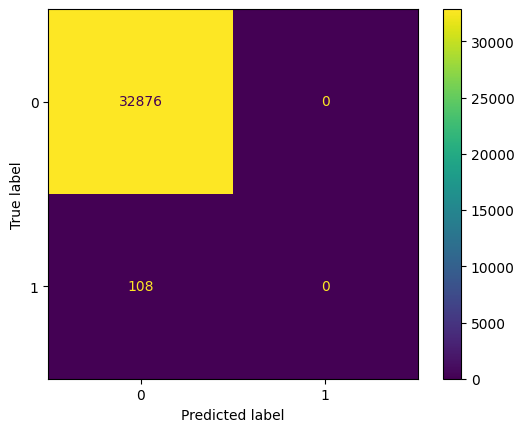

In [62]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

In [63]:
from sklearn.metrics import average_precision_score, auc

precision2, recall2, threshold = precision_recall_curve(y_test, y_pred_binary)
prauc = auc(precision2, recall2)
print("PRAUC: ", prauc)


PRAUC:  0.49836284259034686


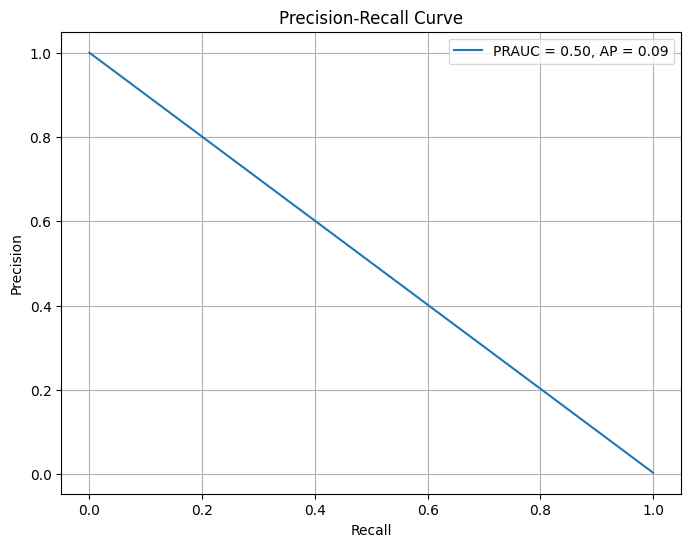

In [64]:
# Calculate the Average Precision (AP) to display in the plot
ap = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall2, precision2, label=f'PRAUC = {prauc:.2f}, AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()